# Analysis of night clusters
This extends from the creation of night clusters and looks to analyse and compare them. Here we analyse some statistics behind them before delving deeper. Putting focus on cluster 2 and 3 as being quite different in the profile of the variables, lets first start to look at how the profiles are different, from the perspective of their overnight glucose. We can shorten the observed period to between 22:00 and 06:00 which - although arbitrary - is more likely to represent a sleeping period for individuals. Using this, we can then look at the BG profiles and measure at each interval if the BG is statistically different.


In [3]:
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

from src.nights import Nights, consolidate_df_from_nights
from datetime import time
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import pandas as pd


2025-07-03 20:39:32.572 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [67]:

night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features()
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)
df_to_compare = analyser.return_dataset_with_clusters()


2025-07-03 23:05:21.054 | INFO     | src.nights:_calculate_overall_stats:158 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction: 100%|██████████| 30/30 [00:43<00:00,  1.47s/it]


Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
<class 'numpy.ndarray'>
Dropped features from scaling: {'iob max__count_above__t_100', 'cob max__minimum', 'cob mean__minimum'}
PCA reduced dimensions from 75 to 2.


Now we take the subset of the timeseries that we deem an 'overnight' period and compare the blood glucose between them.

In [81]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []

for zip_id, df_ind in df_to_compare.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))
from src.dba import get_dba_and_variance

df_overnight = consolidate_df_from_nights(nights_objects)

variables = ['cob mean', 'iob mean', 'bg mean']
cluster_dba_dfs = {}
df_long_bg = pd.DataFrame(columns=['cluster', 'time', 'bg mean'])
col = ('bg mean', 'dba')
for c, df_c in df_overnight.groupby('tsne_cluster_label'):
    df_dba = get_dba_and_variance(df_c[variables], night_start.hour, morning_end.hour, rolling_window=3)
    cluster_dba_dfs[c] = df_dba
    data = {'cluster': c, 'time': df_dba['time'].astype(str), 'bg mean': df_dba[col]}
    df_long_bg = pd.concat([df_long_bg, pd.DataFrame(data)])

df_long_bg


C:\Users\ross\AppData\Local\Temp\ipykernel_2712\3172771283.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long_bg = pd.concat([df_long_bg, pd.DataFrame(data)])


,cluster,time,bg mean
0,0,22:00:00,240.570157
1,0,22:30:00,181.002089
2,0,23:00:00,156.418565
3,0,23:30:00,133.804761
4,0,00:00:00,163.559049
...,...,...,...
11,3,03:30:00,131.668613
12,3,04:00:00,131.590859
13,3,04:30:00,131.669934
14,3,05:00:00,124.204089


In [82]:
arr_c2 = df_long_bg[df_long_bg['cluster']==2]['bg mean'].to_list()
arr_c3 = df_long_bg[df_long_bg['cluster']==3]['bg mean'].to_list()
tstat, pval = ttest_ind(arr_c2, arr_c3)
print(f'Cluster 2 vs Cluster 3 t-test, pval: {tstat, pval}')

Cluster 2 vs Cluster 3 t-test, pval: (np.float64(-3.075481255681117), np.float64(0.004453754679636925))


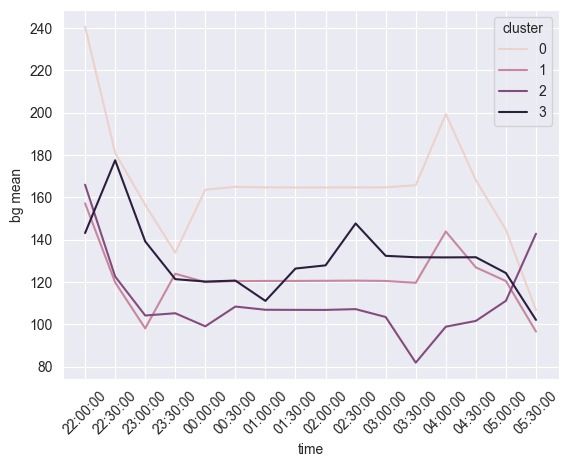

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(df_long_bg, x='time', y='bg mean', hue='cluster', markers='cluster',  ax=ax)
plt.xticks(rotation=45)
plt.show()

In [85]:
from dtw import dtw
def dtw_distance(arr1, arr2):
    distance, _, _, _ = dtw(arr1, arr2, dist=lambda x, y: abs(x - y))
    return distance

for c1, df_c1 in df_long_bg.groupby('cluster'):
    for c2, df_c2 in df_long_bg.groupby('cluster'):
        if c1 < c2:
            arr1 = df_c1['bg mean'].to_list()
            arr2 = df_c2['bg mean'].to_list()
            distance = dtw_distance(arr1, arr2)
            print(f'DTW distance between cluster {c1} and cluster {c2}: {distance}')

DTW distance between cluster 0 and cluster 1: 485.6091665791227
DTW distance between cluster 0 and cluster 2: 294.5946421593503
DTW distance between cluster 0 and cluster 3: 475.84423821239074
DTW distance between cluster 1 and cluster 2: 244.59876141059084
DTW distance between cluster 1 and cluster 3: 136.77153538870704
DTW distance between cluster 2 and cluster 3: 249.648603833683


In [59]:
data = {'cluster': 2, 'bg mean': arr_c2}
pd.DataFrame(data)

,cluster,bg mean
0,2,142.616690
1,2,177.450212
2,2,138.782366
3,2,121.280425
4,2,120.077286
5,2,109.707604
6,2,126.547293
7,2,127.105738
8,2,128.061135
9,2,148.291447


In [74]:
df_long_bg[df_long_bg['cluster']==2]['bg mean'].to_list()

[165.9173371025243,
 122.57235118628894,
 104.15746359763739,
 105.22060772468303,
 99.04747950583187,
 108.37866666840345,
 106.8611326977215,
 106.81905304225145,
 106.79206189856065,
 107.16639910246197,
 103.44217964454934,
 81.8820563581653,
 98.86567389446756,
 101.60208045830161,
 111.09665581839425,
 142.78035848075098]